<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/cam_tutorial_GunPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Model Interpretation for GunPoint Dataset
> CAM and GRAD-CAM for the GunPoint univariate time series dataset

In [ ]:
# Run this cell to install the latest version of fastai shared on github
!pip install git+https://github.com/fastai/fastai.git

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
!pip install git+https://github.com/fastai/fastcore.git

In [ ]:
# Run this cell to install the latest version of timeseries shared on github
!pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

# Class Activation Map (CAM) and Grafient-CAM (GRAD-CAM) Tutorial
> Both CAM and GRAD-CAM allow producing ‘visual explanations’ on how a Convolutional Neural Network (CNN) model based its classification and therefore help interpreting the obtained results. The InceptionTime model is used as an illustration in this notebook.

## GunPoint Dataset
> This dataset involves one female actor and one male actor making a
motion with their hand. The two classes are: Gun-Draw and Point:
For Gun-Draw the actors have their hands by their sides. They draw
a replicate gun from a hip-mounted holster, point it at a target
for approximately one second, then return the gun to the holster,
and their hands to their sides. For Point the actors have their gun
by their sides. They point with their index fingers to a target for
approximately one second, and then return their hands to their
sides. For both classes, we tracked the centroid of the actor's
right hands in both X- and Y-axes, which appear to be highly
correlated. The data in the archive is just the X-axis.


![](images/gunpoint.png)

## Training a model

In [ ]:
# You can choose any of univariate dataset listed the `data.py` file
path = unzip_data(URLs_TS.UNI_GUN_POINT)

In [ ]:
dsname =  'GunPoint'
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('C:/Users/fh/.fastai/data/GunPoint/GunPoint_TRAIN.arff'),
 Path('C:/Users/fh/.fastai/data/GunPoint/GunPoint_TEST.arff')]

In [ ]:
# num_workers=0 is for Windows platform
dls = TSDataLoaders.from_files(bs=64,fnames=fnames, num_workers=0) 

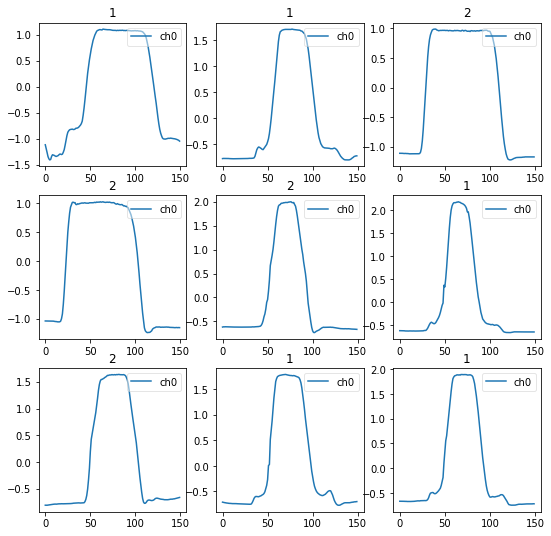

In [ ]:
dls.show_batch(max_n=9)

In [ ]:
learn = ts_learner(dls)
learn.fit_one_cycle(25, lr_max=1e-3) 

epoch,train_loss,valid_loss,accuracy,time
0,1.314982,0.692901,0.575000,00:08
1,1.291740,0.693081,0.550000,00:00
2,1.171116,0.694189,0.425000,00:00
3,1.108719,0.695350,0.425000,00:00
4,0.972143,0.696890,0.425000,00:00
5,0.864975,0.700227,0.425000,00:00
6,0.778819,0.703110,0.425000,00:00
7,0.703747,0.706291,0.425000,00:00
8,0.641936,0.710956,0.425000,00:00
9,0.592867,0.714422,0.425000,00:00


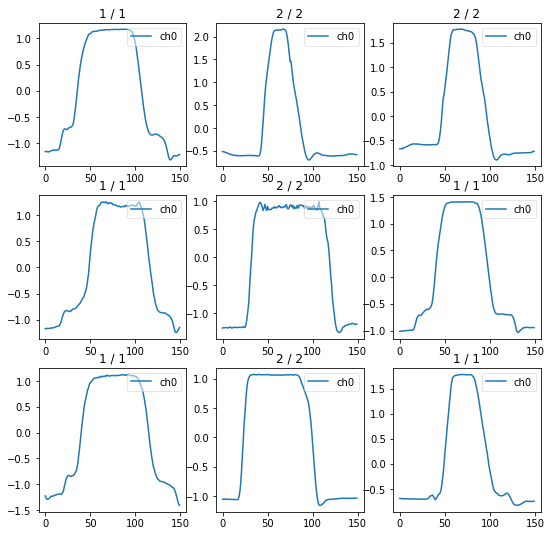

In [ ]:
learn.show_results()

In [ ]:
model = learn.model.eval()

In [ ]:
model[5]

SequentialEx(
  (layers): ModuleList(
    (0): InceptionModule(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (convs): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
        (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      )
      (maxpool_bottleneck): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (bn_relu): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (1): Shortcut(
      (act_fn): ReLU(inplace=True)
      (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

## Decoding class labels 

In [ ]:
# i2o() function
# Converting CategoryTensor label into the human-readable label
lbl_dict = dict([
    (0, 'Gun'),   
    (1, 'Point')]
)
def i2o(y):
    return lbl_dict.__getitem__(y.data.item())
    # return lbl_dict.__getitem__(int(dls.tfms[1][1].decodes(y)))

## Creating a customized batch :  list of 2 items 
> Note: This is not a batch in literal sense as used using `DataLoader.one_batch()` method. It just a list of some dataset items
- batch\[0\]: corresponds to Gun gesture
- batch\[1\]: corresponds to Point gesture

In [ ]:
idxs = [0,3]
batch = get_batch(dls.train.dataset, idxs)
# len(batch), type(batch)

## Plotting CAM for several dataset items in one shared figure 
> Example: the function expects a list of `items` and plots CAM for the provided items list.

### Class Activation Map (CAM)
This option calculates the activations values at the selected layer.By default the activations curves are plotted in one single figure.

`func_cam=cam_acts` : activation function name (activation values at the chosen model layer). It is the default value
 
The figure title `[Gun - Point] - CAM - mean` should be read as follow:
- `Gun`     : class of the first curve
- `Point`   : class of the second curve
- `CAM`     : activation function name (activation values at the chosen model layer)
- `mean`    : type of reduction (read the explanation below: 4 types of reductions)

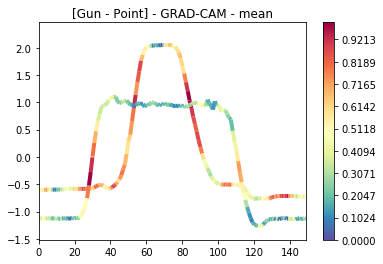

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts) # default:  func_cam=cam_acts, multi_fig=False, figsize=(6,4)

### Plot each time series curve in a separate figure  

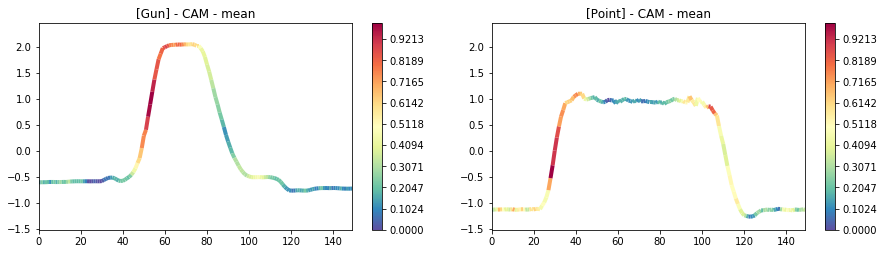

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, multi_fig=True) # default: func_cam=cam_acts, figsize=(13,4)

### Gradiant Class Activation Map (GRAD-CAM)
This option calculates the gradient activations values at the selected layer.

We supply the argument `func_cam=grad_cam_acts` to calculate the Gradient-Class Activation Map (GRAD-CAM)
> Note: another palette is also used in this example: `cmap=CMAP.seismic`

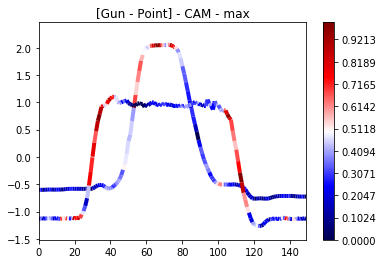

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=cam_acts, reduction='max', cmap=CMAP.seismic)

### Using RAW activation values: `force_scale=False` (Non-scaled values)
By default, both `func_cam=grad_cam_acts` (GRAD-CAM) and `reduction=mean` are used
In this example, we are plotting the raw activation values (by default GRAD-CAM). Notice the values on the cmap color palette.
> We can supply a user-defined `func_cam`. See here below an example with a custom defined function `cam_acts_1`

> Pay attention to the `scale` values. Instead of being between [0..1], they are between th min and the max of the activation raw values

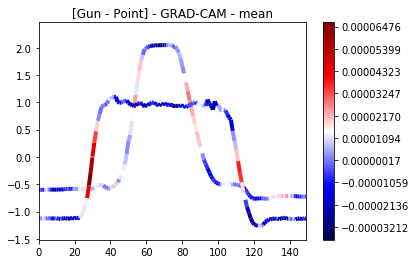

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts , force_scale=False, cmap='seismic')

## 4 types of `reduction`
When raw activities are caluculated, we obtain a tensor of [128, 150]. 128 corresponds to the number of channels. Whereas 150 represents the data points. Since the original time series is a [1, 128] tensor (univariate time series), we need to reduce the [128, 150] tensor to [1, 150]. Therefore, we have several types of reductions. 

`show_cam()` offers 4 types of reductions:
- `mean` (default)
- `median` 
- `max`
- `mean_max` (average of mean and max values)

### Using `reduction='max'`
`mean` is the default reduction. Here below, we use `max` reduction

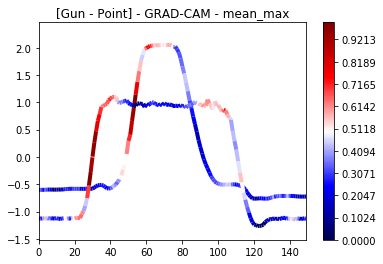

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, reduction='mean_max', cmap=CMAP.seismic)

### Plotting scattered lines

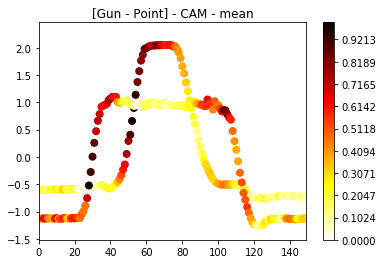

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, scatter=True, cmap=CMAP.hot_r)

## Plotting CAM for a batch of items 
> We can also feed the show_cam() a full batch return straight from `DataLoaders` `one_batch() method as shown here below

### Creating a batch of 5 items

In [ ]:
dls.train = dls.train.new(bs=5)
batch = dls.train.one_batch()

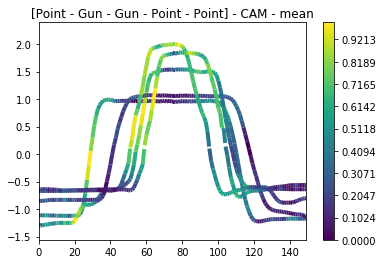

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis)

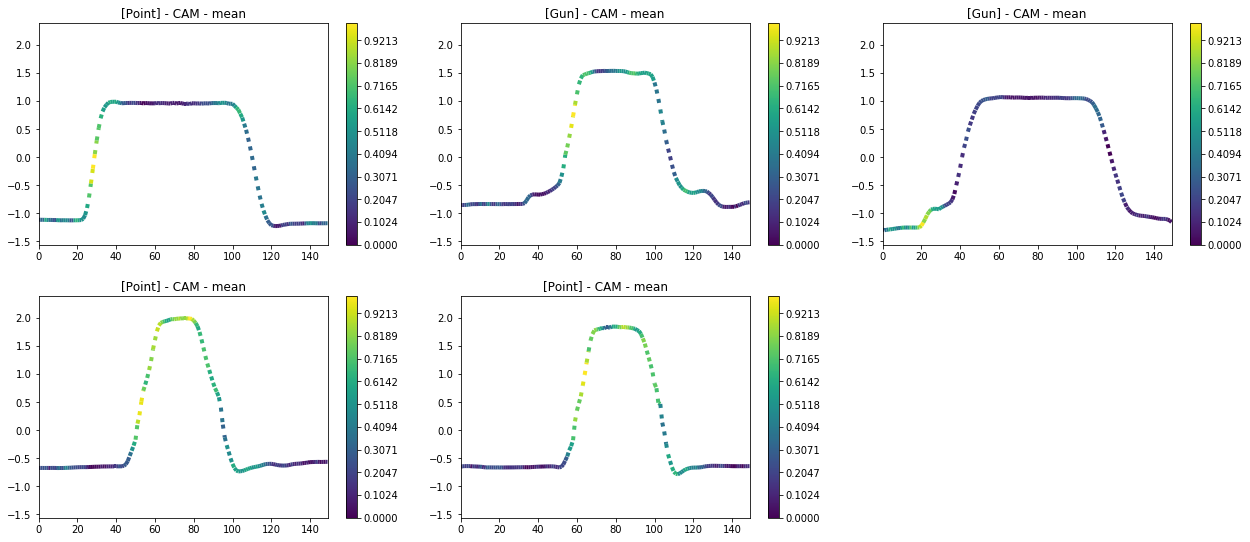

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap='viridis', multi_fig=True, figsize=(18, 8), linestyles='dotted')

## Plotting CAM for a single dataset item 
> We can also feed the `show_cam()` a single item

In [ ]:
idxs = [0]
batch = get_batch(dls.train.dataset, idxs)

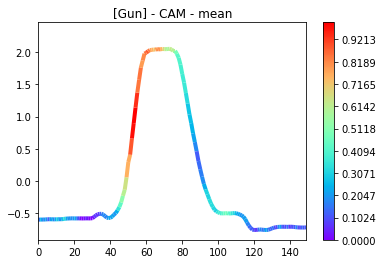

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap='rainbow')

## Palette (`cmap`), Line width, and Line Styles

> There are `164` different palettes.  Check out `CMAP` class and its autocompletion

> line styles : 'solid' | 'dashed' | 'dashdot' | 'dotted'



In [ ]:
# reload the batch with 2 items used earlier
idxs = [0, 3]
batch = get_batch(dls.train.dataset, idxs)

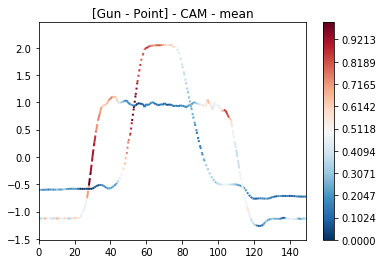

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap='RdBu_r', linewidth=2, linestyles='dotted')

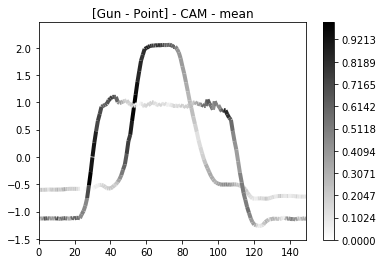

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap='gist_gray_r')

![](images/nature-red-forest-leaves.jpg)
